## Getting Data

In [74]:
import torch
from torch import nn
from torch.nn import functional as F

torch.manual_seed(3791)

batch_size = 4 # Number independant sequences of tokens we will process in parrallel
block_size = 8 # Maximum context length for predictions

with open('the_lord_of_the_rings.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

def get_batch(data):
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y 


## Self Attention


Using this famous paper: https://arxiv.org/pdf/1706.03762.pdf

---

### Embedding Table

We need to use an Embedding table to capture and update the relationships between characters in the vocab list as we go.

In [87]:
test_init = torch.zeros((1, 1), dtype=torch.long)

test_embedding = nn.Embedding(5, 5)

try:
    for i in range(6):
        print(test_embedding(torch.tensor([i])))
except Exception as e:
    print(e)

tensor([[-1.2100,  0.1014,  1.1654,  1.0570,  0.2988]],
       grad_fn=<EmbeddingBackward0>)
tensor([[-1.7554, -0.7894,  1.0513,  0.6006, -0.8928]],
       grad_fn=<EmbeddingBackward0>)
tensor([[-0.1085,  0.6277,  2.6693,  0.1526,  0.7515]],
       grad_fn=<EmbeddingBackward0>)
tensor([[-1.0181, -2.0176,  0.1408,  0.3478,  0.8696]],
       grad_fn=<EmbeddingBackward0>)
tensor([[ 1.8462,  0.4879, -1.2586, -1.0901,  0.0101]],
       grad_fn=<EmbeddingBackward0>)
index out of range in self


The table is embedding table is initialised with random weights and then you can call the values by "querying" the table for particular tensor. See above we ar calling with tensors [0], ... , [4] and getting the embedding tensor for each. This can also be done with a tensor of 2 dimensions to get multiple embedding tensors at once.

In [89]:
test_embedding(torch.tensor([[0], [1]]))

tensor([[[-1.2100,  0.1014,  1.1654,  1.0570,  0.2988]],

        [[-1.7554, -0.7894,  1.0513,  0.6006, -0.8928]]],
       grad_fn=<EmbeddingBackward0>)

See how with a 2x1 tensor we can call two embeddings. Thus we initialise our Bigram model with an embedding table.

In [93]:
class ExampleModel(nn.Module):
    def __init__(self, vocab_size) -> None:
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

model = ExampleModel(len(chars))
model.token_embedding_table(torch.tensor([0]))

tensor([[-0.0876,  3.3286,  0.4977, -0.9609,  0.8946,  0.4177, -0.1512, -0.2861,
         -0.5527,  1.3140, -1.0525, -0.3853, -0.0423, -0.5409,  0.7870, -0.3939,
         -0.3354,  0.5560, -1.4857,  2.3415, -0.2716, -0.9588, -0.0415, -0.4185,
          0.9533,  1.0256, -0.4132,  0.6246,  1.0264, -0.8354, -1.6811, -1.7241,
          0.7894,  0.9853, -1.1641, -0.4127,  0.0541, -0.7060, -0.9298, -1.1425,
          0.2372,  0.1258, -0.2515, -0.9482,  1.5741, -1.5166,  1.0181, -0.7520,
          0.1802, -0.8544, -0.6815,  1.7143,  0.0286, -0.7098,  1.1863,  0.9302,
         -0.6686, -1.0945, -1.7122,  0.2750,  0.7910, -0.1814,  0.3446,  0.9911,
         -0.3141, -0.4402,  0.2398, -0.7743,  0.6875,  0.7678,  0.0501,  2.2414,
          0.7806, -0.4956, -0.3297,  0.9255, -0.1529,  0.7153, -0.1650,  0.2045,
         -1.3085, -0.5446, -0.4912, -0.5072, -0.1396,  0.2392, -1.3948, -1.6194,
         -1.9468,  0.3231]], grad_fn=<EmbeddingBackward0>)

This is the intialised embedding of the first char " ".

---

### Forward

All Neural Network models require a feed forward process to be defined. This will require that we make a prediction, and calulate the loss of that prediction vs the target.

In [98]:
xb, yb = get_batch(train_data)
print(xb[0])
print(decode(xb[0].tolist()))
print()
print(yb[0])
print(decode(yb[0].tolist()))

tensor([59,  1, 75, 53, 71,  1, 53,  1])
g was a 

tensor([ 1, 75, 53, 71,  1, 53,  1, 70])
 was a r


As you can see from above, the first example in the batch has the input (idx) as the set of chars and then the target is shifted one along.

In [101]:
prediction = model.token_embedding_table(xb[0]) 
prediction.shape

torch.Size([8, 90])

So the model has used the existing weights to make a prediction. All it has done is call the embeddings of each on the 8 chars in the input. This returns 8 1x90 tensors giving the weights of the prediction that the next char will be each of the chars in the vocab list.

We can call for the whole batch together to parallelise the prediction.

In [105]:
multi_prediction = model.token_embedding_table(xb) 
multi_prediction.shape

torch.Size([4, 8, 90])

This gets us a (Number of Batches)x(Size of Batch)x(Vocab Size) tensor.

The naming convetion of this is logits which is a Batch x Time x Channel tensor.

Once, we have this prediction we need to calculated the loss between the logits and the targets using cross entropy. 

In [113]:
logits = model.token_embedding_table(xb) 
print(logits.shape)
print(yb.shape)

torch.Size([4, 8, 90])
torch.Size([4, 8])


But to do this we need to rearrange both tensors.

In [128]:
targets = yb
logits = model.token_embedding_table(xb) 
B, T, C = logits.shape

try:
    loss = F.cross_entropy(logits, targets)
except Exception as e:
    print("logits", logits.shape)
    print("targets", targets.shape)
    print(e)

print("-- Reshape --")
logits = logits.view(B*T, C)
targets = targets.view(B*T)

loss = F.cross_entropy(logits, targets)
print(logits.shape)
print(targets.shape)
print(loss)
print("loss:", loss.tolist())

logits torch.Size([4, 8, 90])
targets torch.Size([4, 8])
Expected target size [4, 90], got [4, 8]
-- Reshape --
torch.Size([32, 90])
torch.Size([32])
tensor(4.9871, grad_fn=<NllLossBackward0>)
loss: 4.987088203430176


Combing the batches into a single dimension 8x4 -> 32 allows the loss function to work on the whole channel. The for each of the 32 individual samples the loss is calculated and aggregated to a single value.

We can now add this as the forward method of the model.

In [165]:
class ExampleModel(nn.Module):
    def __init__(self, vocab_size) -> None:
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # Batch x Time x Channel, tensor prediction of what is next
        logits = self.token_embedding_table(idx) 

        if targets is None: # For predictions
            loss = None
        else:
            # Based on the PyTorch docs we need a B*C x T tensor to calcualate loss
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits , loss 

In [130]:
model = ExampleModel(len(chars))
inputs, targets = get_batch(train_data)

model(inputs, targets)

(tensor([[ 0.3025,  0.3713, -0.7302,  ...,  0.5049,  0.9773,  1.0095],
         [-0.0400, -0.6434,  0.0299,  ..., -0.3823, -1.0193,  1.3180],
         [-1.9939, -0.0510, -1.5148,  ...,  0.5202, -0.4177,  0.8031],
         ...,
         [ 0.1601,  0.5197, -0.3772,  ..., -0.4490,  1.2770, -0.0861],
         [-0.5634, -0.7825, -0.5443,  ..., -0.6847, -1.7515, -0.9944],
         [-0.0400, -0.6434,  0.0299,  ..., -0.3823, -1.0193,  1.3180]],
        grad_fn=<ViewBackward0>),
 tensor(5.0002, grad_fn=<NllLossBackward0>))


---

### Generation

The next thing to add to the model is a method that askes it to generate text based on the current embedding weights. This will be very similar to the forward method but instead of calculating the loss we turn the logits into an output tensor.

Choosing a random token:

In [158]:
token_id = 26
decode([token_id])

'B'

So, can now just get the logits from the forward method.

In [164]:
idx = torch.tensor([[token_id]])
logits, loss = model(idx)
logits = logits[:, -1, :] 
logits


tensor([[ 1.9797,  1.2903, -1.6743, -0.3600, -0.5906,  0.3411, -0.1042, -1.5382,
          0.9629, -2.9014, -0.7761, -0.3944,  0.1249,  1.0574,  0.9309,  2.5278,
         -1.6562, -0.0774, -0.1135, -0.5326, -0.0529,  0.0484,  0.4165,  2.8192,
         -1.1526,  1.8900,  1.4683,  0.3977,  0.5167, -0.9430,  0.3284,  0.9323,
          0.2923,  0.8177,  0.3238, -0.8927,  0.4464,  0.1060, -2.2830, -0.5807,
         -0.3417, -0.9795,  0.2206, -0.0862, -0.8546, -1.0500,  0.2394,  0.3870,
         -0.4859,  0.0604, -0.2484, -1.1636,  0.5333, -1.0060, -0.6396, -1.0199,
         -0.8887, -0.6764, -0.2995,  0.0338,  0.1968,  0.0406, -0.3009,  0.5377,
          0.7671, -0.0486, -2.3267, -0.8018, -0.9481, -0.8379,  0.2353, -0.3139,
         -0.2043, -2.3731, -1.6635,  0.3826, -0.5835, -0.2579, -0.1750, -0.7196,
          0.2570, -0.7750,  1.0990,  0.4749,  0.6344,  0.4972,  0.5820, -0.3775,
         -1.8681, -0.8289]], grad_fn=<SliceBackward0>)

Now we can softmax to get the probabilty of each character.

In [166]:
probs = F.softmax(logits, dim=-1) 
probs

tensor([[0.0546, 0.0274, 0.0014, 0.0053, 0.0042, 0.0106, 0.0068, 0.0016, 0.0197,
         0.0004, 0.0035, 0.0051, 0.0085, 0.0217, 0.0191, 0.0944, 0.0014, 0.0070,
         0.0067, 0.0044, 0.0072, 0.0079, 0.0114, 0.1264, 0.0024, 0.0499, 0.0327,
         0.0112, 0.0126, 0.0029, 0.0105, 0.0192, 0.0101, 0.0171, 0.0104, 0.0031,
         0.0118, 0.0084, 0.0008, 0.0042, 0.0054, 0.0028, 0.0094, 0.0069, 0.0032,
         0.0026, 0.0096, 0.0111, 0.0046, 0.0080, 0.0059, 0.0024, 0.0129, 0.0028,
         0.0040, 0.0027, 0.0031, 0.0038, 0.0056, 0.0078, 0.0092, 0.0079, 0.0056,
         0.0129, 0.0162, 0.0072, 0.0007, 0.0034, 0.0029, 0.0033, 0.0095, 0.0055,
         0.0061, 0.0007, 0.0014, 0.0111, 0.0042, 0.0058, 0.0063, 0.0037, 0.0097,
         0.0035, 0.0226, 0.0121, 0.0142, 0.0124, 0.0135, 0.0052, 0.0012, 0.0033]],
       grad_fn=<SoftmaxBackward0>)

We can the sample 1 tensor based on the multinomial distribtion across the probabilities.

In [176]:
torch.multinomial(probs, num_samples=1)

tensor([[64]])

It will help to demonstrate how this works graphically.

In [187]:
results_dict = {i: 0 for i in range(0, 90)}
for _ in range(10000):
    result = torch.multinomial(probs, num_samples=1)
    results_dict[result[0].tolist()[0]] += 1

In [188]:
prob_dict = {}
for i, prob in enumerate(probs[0].tolist()):
    prob_dict[i] = prob

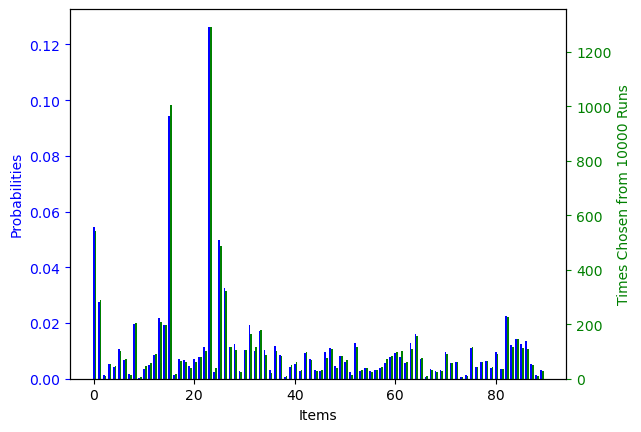

In [191]:
import matplotlib.pyplot as plt
import numpy as np

keys = list(prob_dict.keys())
values1 = list(prob_dict.values())
values2 = list(results_dict.values())

bar_width = 0.35

r1 = np.arange(len(keys))
r2 = [x + bar_width for x in r1]

fig, ax1 = plt.subplots()

ax1.bar(r1, values1, width=bar_width, label='Dataset 1', color='b')
ax1.set_xlabel('Items')
ax1.set_ylabel('Probabilities', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.bar(r2, values2, width=bar_width, label='Dataset 2', color='g')
ax2.set_ylabel('Times Chosen from 10000 Runs', color='g')
ax2.tick_params('y', colors='g')

plt.show()


See how the probability and rate of selection relate to one another.

Finally we can piece this all together.

In [197]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size) -> None:
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
    
    def forward(self, idx, targets=None):
        logits = self.token_embedding_table(idx) 

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits , loss 
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :] 
            probs = F.softmax(logits, dim=-1) 
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
    
m = BigramLanguageModel(len(chars)) 

print("Batch:", decode(xb[0].tolist()))
gen = m.generate(xb, 5)
print("Generation:", decode(gen[0].tolist()))


Batch: g was a 
Generation: g was a _eAeí


So, it works. We just need to train it.

---

### Training Loop

The training loop is very simple at this stage. The only additional componant we need is an optimizer which controls the progressive small steps towards the optimum (lowest, in this case) loss.  

In [199]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

With that we can step through the simple loop:

For a given number of steps:
- Get a batch of the training data
- Calculate the loss
- Take a step in a direction towards the lower loss. 

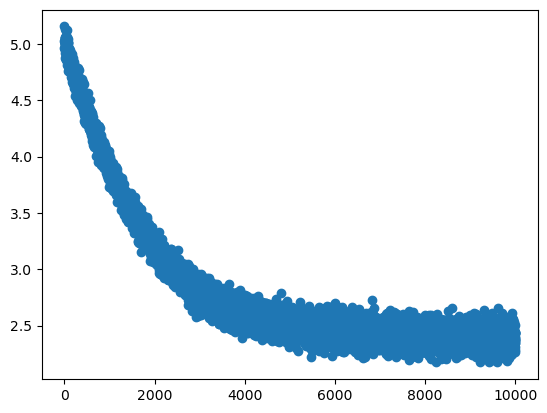

In [200]:
batch_size = 32
number_of_steps = 10000
losses = []


for steps in range(number_of_steps):
    xb, yb = get_batch(train_data)          # Getting batch of training data
    logits, loss = m(xb, yb)                # Calculate loss

    optimizer.zero_grad(set_to_none=True)   
    loss.backward()                         # Back propagate the loss.
    optimizer.step()                        # Adjust the optimizer.

    losses.append(loss.item())              # Storing losses to plot.

plt.scatter(range(0, 10000), losses)

This does pretty well and should reflect in the improved generation.

In [202]:
print("Batch:", decode(xb[0].tolist()))
gen = m.generate(xb, 15)
print("Generation:", decode(gen[0].tolist()))

Batch: inder of
Generation: inder of wowey rgr that


It's not Tolkien but it does seem to understand the english language better now.

---

Every token will emitt a vector with a query and a key.

The query dot products with the keys of all tokens 

<br>

### Single Head of Self-attention

In [22]:
B, T, C = 2, 3, 4
x = torch.randn(B, T, C)
x

tensor([[[ 1.4935, -1.6276,  0.0872, -1.3071],
         [ 0.6953,  0.0186,  0.2562, -1.5210],
         [-1.2459,  0.0640, -0.9278, -0.9948]],

        [[ 1.1397,  0.2125, -1.1663,  0.1579],
         [ 0.2349, -0.1376,  0.5638, -1.3693],
         [-1.0884, -0.3520,  0.4274,  0.7945]]])

In [23]:
head_size = 2
key = nn.Linear(C, head_size, bias=False)
key(x)

tensor([[[ 1.1424, -0.9539],
         [ 0.2758, -0.5659],
         [-0.1669,  0.0464]],

        [[ 0.2494, -0.4233],
         [ 0.1964, -0.3667],
         [-0.2130,  0.5483]]], grad_fn=<UnsafeViewBackward0>)

The important thing here is that pytorch as initialised some random weights for us. Therefore by default the self attention head starts out with random weights that we will adjust through back-prop.

In [24]:
torch.manual_seed(3791)
B, T, C = 4, 8, 6
x = torch.randn(B, T, C)

head_size = 16

key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

k = key(x) # B x T x head_size
q = query(x)
v = value(x)

wei = q @ k.transpose(-2, -1) # B x T x 16 @ B x 16 x T -----> (B, T, T) matrix

tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0 , float('-inf'))
wei = F.softmax(wei, dim=1)

out = wei @ v
out.shape

torch.Size([4, 8, 16])

This is now data dependent due to the key and the query being used to generate the wei

In [25]:
wei.shape

torch.Size([4, 8, 8])

High affinity means that some tokens are used more to predict than others and we store and updated the weights for each batch.

<br>

### Self-attention Module Plugged into Bigram


We need to use an Embedding table to capture and update the relationships between characters in the vocab list as we go.

In [27]:
import torch.nn as nn
from torch.nn import functional as F

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size) -> None:
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
    
    def forward(self, idx, targets=None):
        # Batch x Time x Channel, tensor prediction of what is next
        logits = self.token_embedding_table(idx) 

        if targets is None:
            loss = None
        else:
            # Based on the PyTorch docs we need a B*C x T tensor to calcualate loss
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits , loss 
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context.
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :] 
            probs = F.softmax(logits, dim=-1) 
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [45]:
print(train_data[0:97])
print()
print(decode(train_data[0:97].tolist()))

tensor([44, 60, 70, 57, 57,  1, 42, 61, 66, 59, 71,  1, 58, 67, 70,  1, 72, 60,
        57,  1, 29, 64, 74, 57, 66,  8, 63, 61, 66, 59, 71,  1, 73, 66, 56, 57,
        70,  1, 72, 60, 57,  1, 71, 63, 77,  7,  0, 43, 57, 74, 57, 66,  1, 58,
        67, 70,  1, 72, 60, 57,  1, 28, 75, 53, 70, 58,  8, 64, 67, 70, 56, 71,
         1, 61, 66,  1, 72, 60, 57, 61, 70,  1, 60, 53, 64, 64, 71,  1, 67, 58,
         1, 71, 72, 67, 66, 57,  7])

Three Rings for the Elven-kings under the sky,
Seven for the Dwarf-lords in their halls of stone,


Okay so we have our encoded text data and we can see where the same characters get the same token id. 1 is a space for example. 

In [51]:
torch.manual_seed(3791) # Set manual seed for repeatability. There Rings for the Elven-kings... and so on.



m = BigramLanguageModel(len(chars)) 
idx_init = torch.zeros((1, 1), dtype=torch.long)
decode(m.generate(idx_init, max_new_tokens=100)[0].tolist())

'\nQ. XQûb)d9IFF;?Iú_M,KCnáJ9Cíkou cdwâ=O4GE4N 9-wlg7M;:3bjaëu`Y8Ná/)7fYy8\n,ëiWMKë=WëeD upjuUú/qSäc)FTk'

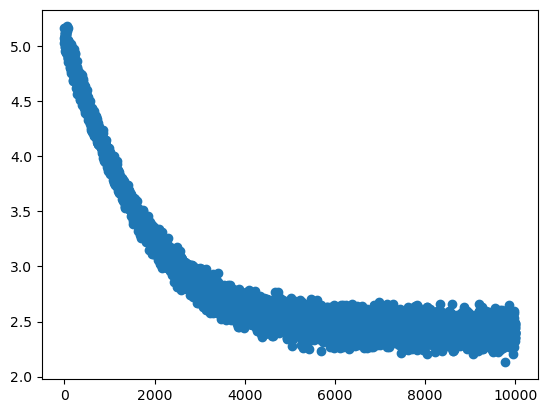

In [33]:
batch_size = 32
number_of_steps = 10000
losses = []
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

for steps in range(number_of_steps):
    xb, yb = get_batch(train_data)

    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

from matplotlib import pyplot as plt

plt.scatter(range(0, 10000), losses)

In [34]:
def generate_text(model, text_length):
    idx_init = torch.zeros((1, 1), dtype=torch.long)
    return decode(model.generate(idx_init, max_new_tokens=text_length)[0].tolist())

print(generate_text(m, 1000))


 eng w se sthet by Fome  wimood rlelbs ay,  s fe.ät iOf aret!ldis Thandsere Fou!ë' é'I anghe s wastunth RFOritheeresepremy: pe hinuent heme hop Th awea`Ridobowhiroot Brs t wngashayoumanut-m FYy wouPif wid frmin heigrd p  ArerKGaroondorCo fi03G; foroto spearen t owitce h ved an Oful Hing if pt oryoof rme wawinean le arlat. theng theark   ind  t. t mm.  n  isaine ?'
 uchut t  Galilin kEntoan a t  irideausited ptrotherd agstheeshere  issat t t  e  ngaá/Ourowe ho t xtit sarouthad?', toond, vee I is; blden'ok wagrd leevemit skeer ors ckery;_, rsabos doutherad wind len, to s oul sande, akiellyshedope se hesude imof f tr wed d whad anthp co ws, m,' akelifoprso jQDebu Br a  eetordofe  ade!
 nd de r hacl ocou yondlle  ss d  _Thatocror  wr t BOver tllvem.'s Ljalf oued. meileyouadans athenghef Fre ashig, t wenass ay iere t. n, wang, f ts me of obad t hedon hin _l ala2Ainod ow ooropee wit Then I touthand s. thas co lld tsh ly ous bEEppofes, tad I R. ty  Cong witur  Ocleche, t s; It Elfu ghe t Tho